# Installation and Setup

In [1]:
import h2o
import fairlearn
import pandas as pd
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-10376486 (build 17.0.13+11-LTS, mixed mode, sharing)
  Starting server from D:\OneDrive\Repos\employee-attrition-ibm\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmp4gesh9nu
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmp4gesh9nu\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmp4gesh9nu\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 17 days
H2O_cluster_name:,H2O_from_python_user_gic36n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.971 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


# Model Interpretation

In [3]:
model_path = "../models/oversampling/2025-03-17_20-56-34/cv/StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731"
best_model = h2o.upload_model(model_path)

# Upload test data
test = h2o.import_file("../data/processed/test_set.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


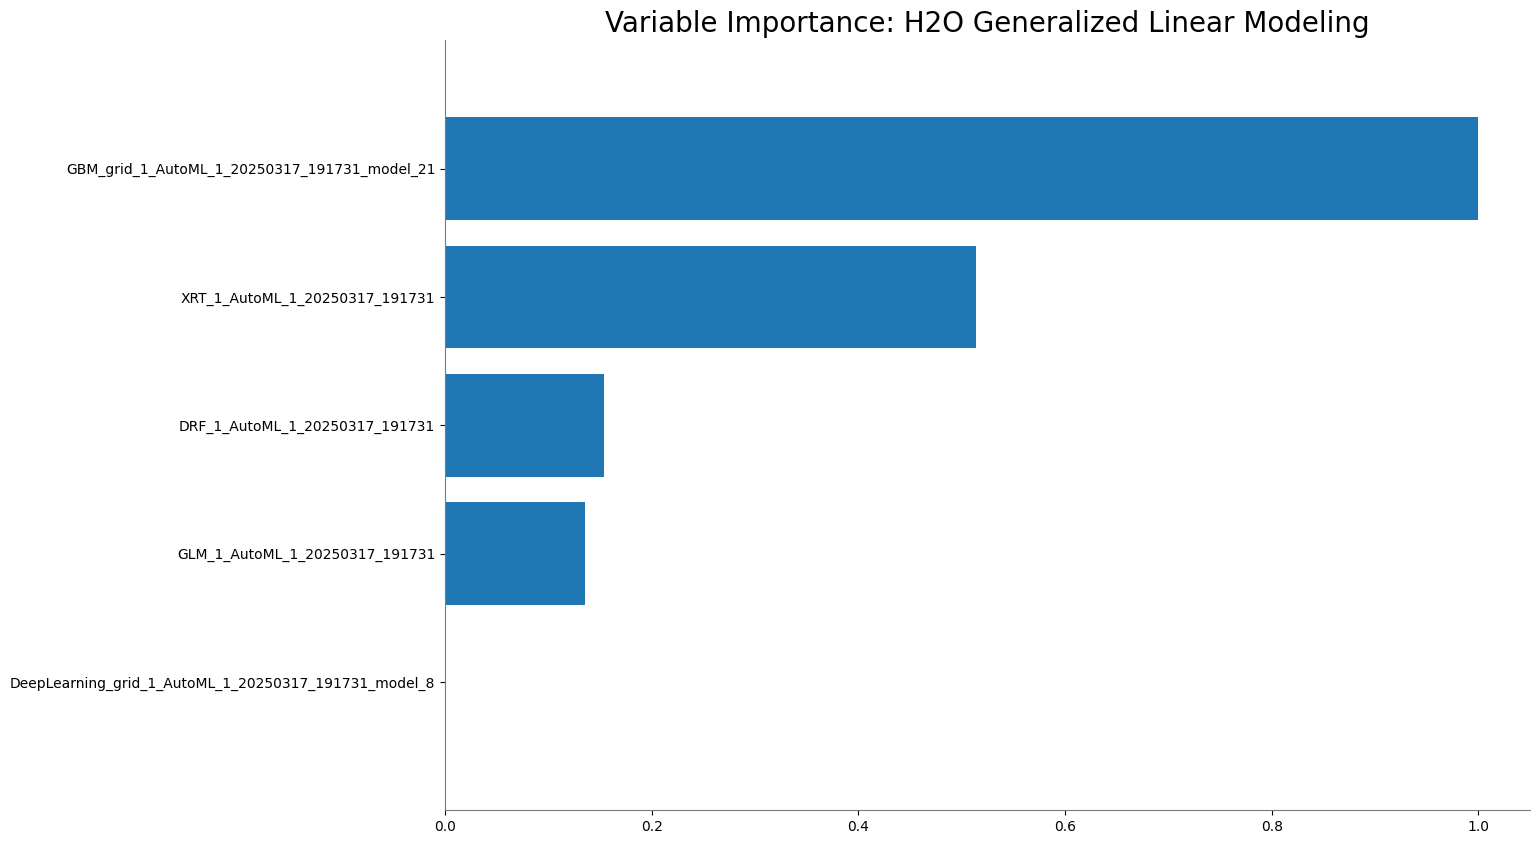

<Figure size 640x480 with 0 Axes>

In [14]:
# Generate the variable importance plot
best_model.metalearner().varimp_plot()

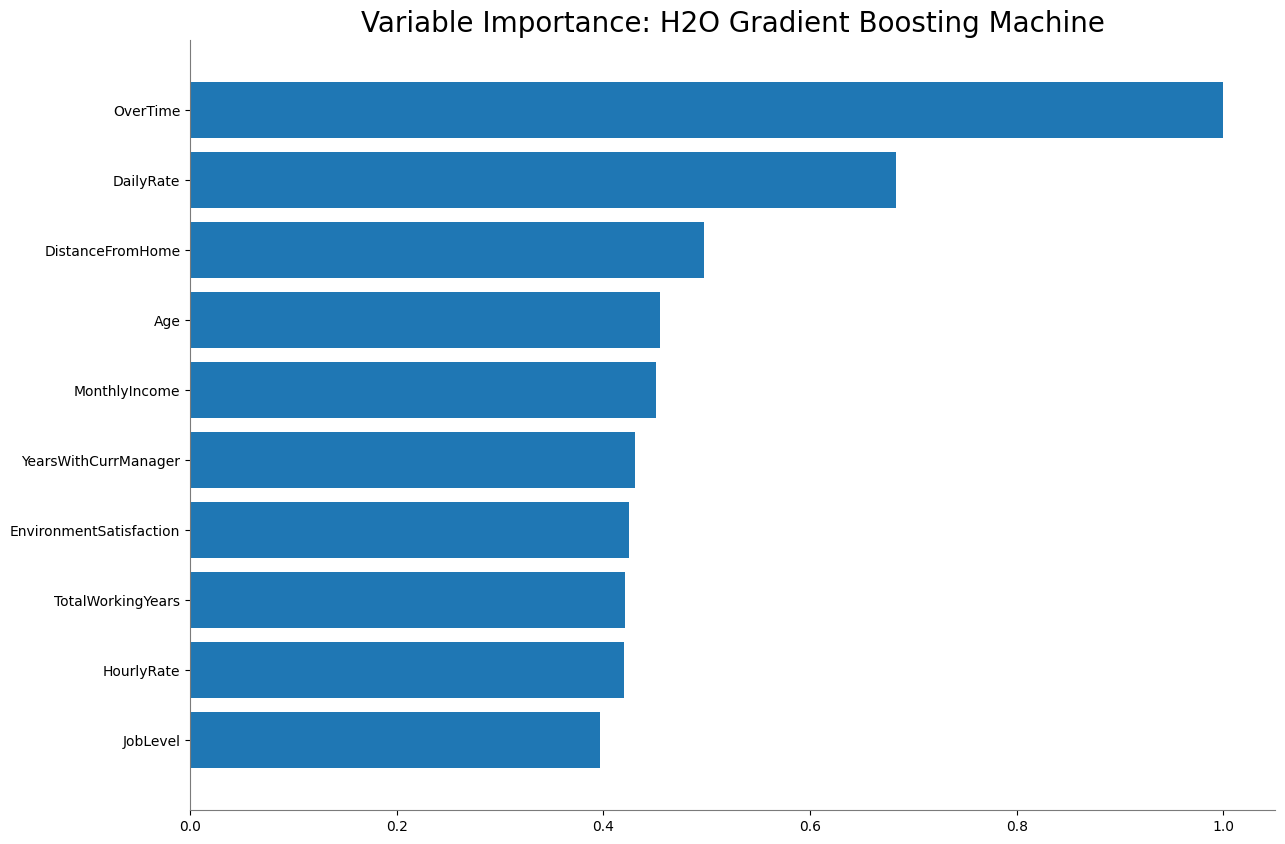

<Figure size 640x480 with 0 Axes>

In [15]:
varimp_df = best_model.metalearner().varimp(use_pandas=True)  # Get variable importance for metalearner
dominant_model_id = varimp_df.iloc[0, 0]  # The model with the highest importance

# Retrieve the dominant base model
dominant_model = h2o.get_model(dominant_model_id)
dominant_model.varimp_plot()

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

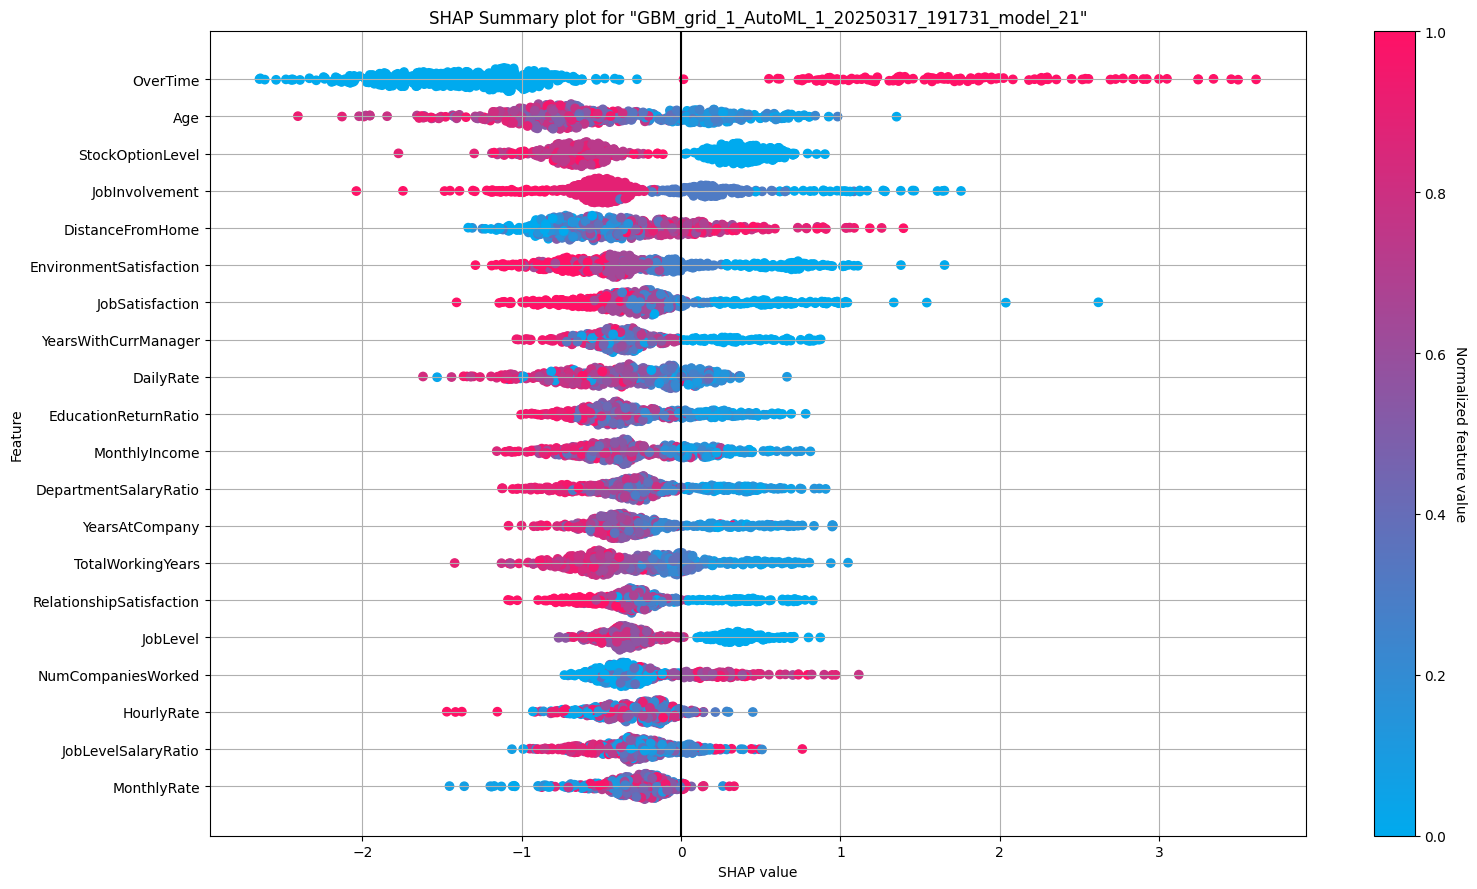

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

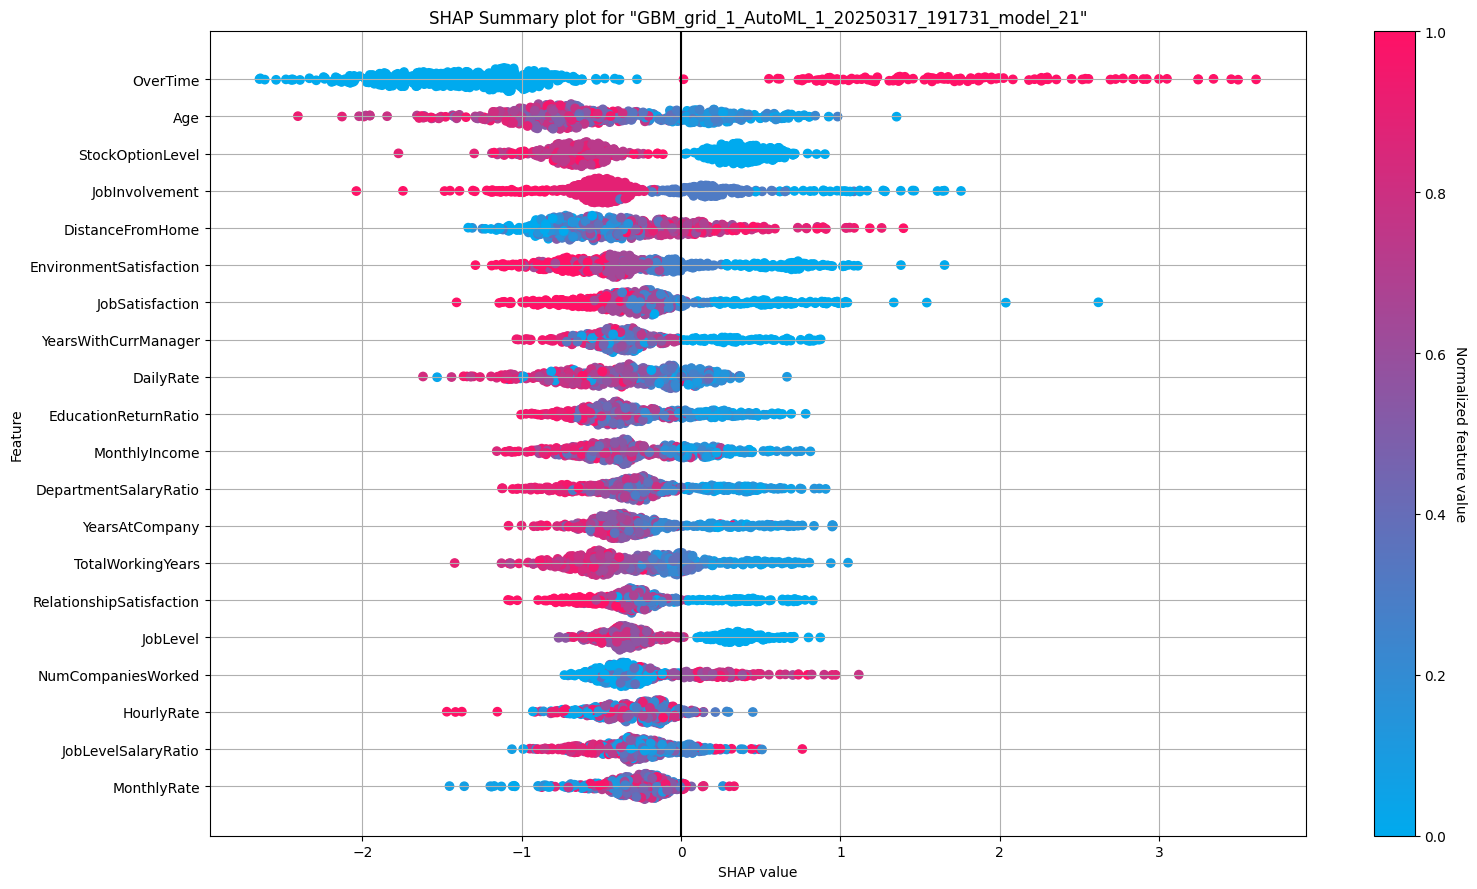

In [16]:
dominant_model.explain(test, include_explanations="shap_summary")
# Not supported for stacked ensembles

# Preprocessing Predictions and Test Data

In [8]:
test_decode = test.as_data_frame()
test_decode['Gender'] = test_decode['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female')
test_decode['OverTime'] = test_decode['OverTime'].apply(lambda x: "Yes" if x == 1 else 'No')

d:\OneDrive\Repos\demo-project\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [9]:
variable_ori_names = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]

for variable_ori_name in variable_ori_names:
    # Ensure only one-hot encoded columns are used
    one_hot_columns = [col for col in test_decode.columns if variable_ori_name+"_" in col]

    # Apply idxmax only to these columns
    test_decode[variable_ori_name] = test_decode[one_hot_columns].idxmax(axis=1).str.replace(variable_ori_name+"_", "")

    # Drop the original one-hot columns
    test_decode.drop(columns=one_hot_columns, inplace=True)

test_decode


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,ManagementStabilityRatio,JobLevelSalaryRatio,DepartmentSalaryRatio,EducationReturnRatio,Attrition,BusinessTravel,Department,EducationField,JobRole,MaritalStatus
0,-1.195770,1.374230,1.949889,0.085020,-1.575150,Male,-0.880062,-2.431178,-0.961159,0.246116,...,1.000000,-0.745834,-0.870527,-0.895721,1,Travel_Rarely,Research & Development,Life Sciences,Laboratory Technician,Single
1,-0.210589,-0.065638,-1.010565,1.061426,0.254538,Male,-1.667098,-1.025818,-0.057768,-1.567373,...,0.533333,-0.910372,-0.521519,-0.509781,0,Travel_Rarely,Sales,Marketing,Sales Executive,Single
2,-0.210589,-0.298595,1.086423,1.061426,-0.660306,Male,0.251303,0.379543,-0.057768,-1.567373,...,0.800000,0.044914,-0.275454,-0.257156,0,Travel_Rarely,Sales,Medical,Sales Executive,Married
3,-0.867377,-0.340725,0.716366,0.085020,0.254538,Male,-0.289785,0.379543,-0.961159,1.152861,...,0.833333,-0.674861,-0.860268,-0.885755,0,Travel_Rarely,Research & Development,Life Sciences,Research Scientist,Single
4,0.555663,-1.490637,-1.010565,1.061426,-0.660306,Female,1.431858,0.379543,-0.961159,-1.567373,...,0.400000,-0.318491,-0.808756,-0.860907,0,Travel_Rarely,Research & Development,Life Sciences,Laboratory Technician,Divorced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,-0.867377,-0.526595,-0.640509,0.085020,1.169383,Female,1.235098,-1.025818,-0.961159,-1.567373,...,0.000000,-1.023682,-0.910689,-0.934737,0,Travel_Rarely,Research & Development,Technical Degree,Research Scientist,Divorced
437,1.431380,-0.013595,-0.640509,-1.867790,-1.575150,Male,1.481047,0.379543,2.652406,-0.660628,...,0.600000,-0.010487,2.807588,3.308324,0,Travel_Rarely,Research & Development,Life Sciences,Research Director,Divorced
438,-0.648447,-1.371681,-0.393804,1.061426,-0.660306,Male,0.497252,-2.431178,-0.057768,0.246116,...,1.000000,0.512231,-0.155081,-0.133574,1,Travel_Rarely,Sales,Life Sciences,Sales Executive,Married
439,-0.210589,0.197057,-0.763861,1.061426,1.169383,Male,1.284288,0.379543,0.845624,1.152861,...,0.800000,-0.854876,0.170183,0.200360,0,Travel_Rarely,Sales,Life Sciences,Sales Executive,Divorced


In [10]:
# Make predictions # Note take h2o takes the CV threshold
predictions = best_model.predict(test)

# Convert H2OFrame to Pandas
predictions = predictions.as_data_frame()

#Reset index
predictions.reset_index(drop=True)
test_decode.reset_index(drop=True)

# Merge predictions with test data
merged_df = pd.concat([predictions,test_decode], axis=1)

# Print df
merged_df

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


d:\OneDrive\Repos\demo-project\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict,p0,p1,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,...,ManagementStabilityRatio,JobLevelSalaryRatio,DepartmentSalaryRatio,EducationReturnRatio,Attrition,BusinessTravel,Department,EducationField,JobRole,MaritalStatus
0,1,0.172978,8.270225e-01,-1.195770,1.374230,1.949889,0.085020,-1.575150,Male,-0.880062,...,1.000000,-0.745834,-0.870527,-0.895721,1,Travel_Rarely,Research & Development,Life Sciences,Laboratory Technician,Single
1,0,0.999844,1.562022e-04,-0.210589,-0.065638,-1.010565,1.061426,0.254538,Male,-1.667098,...,0.533333,-0.910372,-0.521519,-0.509781,0,Travel_Rarely,Sales,Marketing,Sales Executive,Single
2,0,0.999896,1.038397e-04,-0.210589,-0.298595,1.086423,1.061426,-0.660306,Male,0.251303,...,0.800000,0.044914,-0.275454,-0.257156,0,Travel_Rarely,Sales,Medical,Sales Executive,Married
3,0,0.998365,1.635442e-03,-0.867377,-0.340725,0.716366,0.085020,0.254538,Male,-0.289785,...,0.833333,-0.674861,-0.860268,-0.885755,0,Travel_Rarely,Research & Development,Life Sciences,Research Scientist,Single
4,0,0.999937,6.294739e-05,0.555663,-1.490637,-1.010565,1.061426,-0.660306,Female,1.431858,...,0.400000,-0.318491,-0.808756,-0.860907,0,Travel_Rarely,Research & Development,Life Sciences,Laboratory Technician,Divorced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,0,0.965725,3.427474e-02,-0.867377,-0.526595,-0.640509,0.085020,1.169383,Female,1.235098,...,0.000000,-1.023682,-0.910689,-0.934737,0,Travel_Rarely,Research & Development,Technical Degree,Research Scientist,Divorced
437,0,0.999991,8.775803e-06,1.431380,-0.013595,-0.640509,-1.867790,-1.575150,Male,1.481047,...,0.600000,-0.010487,2.807588,3.308324,0,Travel_Rarely,Research & Development,Life Sciences,Research Director,Divorced
438,0,0.864637,1.353629e-01,-0.648447,-1.371681,-0.393804,1.061426,-0.660306,Male,0.497252,...,1.000000,0.512231,-0.155081,-0.133574,1,Travel_Rarely,Sales,Life Sciences,Sales Executive,Married
439,0,1.000000,6.901734e-09,-0.210589,0.197057,-0.763861,1.061426,1.169383,Male,1.284288,...,0.800000,-0.854876,0.170183,0.200360,0,Travel_Rarely,Sales,Life Sciences,Sales Executive,Divorced


# Fairness Evaluation

In [ ]:
# Create function for fairness evaluation
def fairness_eval(attr, merged_df=merged_df):
    
    # Add predictions and sensitive attributes
    sensitive_attribute = merged_df[attr]  # Replace with your sensitive attribute
    true_labels = merged_df["Attrition"]

    # Evaluate fairness metrics
    metrics = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
            "true_positive_rate": true_positive_rate,
            "true_negative_rate": true_negative_rate,
            "false_positive_rate": false_positive_rate,
            "false_negative_rate": false_negative_rate,
            "balanced_accuracy": balanced_accuracy_score,
        },
        y_true=true_labels,
        y_pred=merged_df["predict"],
        sensitive_features=sensitive_attribute
    )

    print(metrics.by_group)

    metrics_to_report = ['selection_rate','true_positive_rate','false_positive_rate']

    # Plotting the bar plots and getting the bar containers
    axes = metrics.by_group[metrics_to_report].plot.bar(
        subplots=True, layout=[1, 3], figsize=[12, 6], legend=None, rot=90
    )

    # Annotating the values on the bars
    for ax in axes.flatten():
        # Loop over all the bars in the plot
        for p in ax.patches:
            # Annotate the bar
            ax.annotate(
                f'{p.get_height():.2f}',  # Display the value with two decimal places
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position: centered above the bar
                textcoords="offset points",  # Use offset points for position adjustment
                xytext=(0, 5),  # Slight vertical offset
                ha='center',  # Center the text horizontally
                fontsize=10  # Font size
            )

    plt.show()


Gender

        accuracy  selection_rate  true_positive_rate  true_negative_rate  \
Gender                                                                     
Female  0.905028        0.005587            0.055556                 1.0   
Male    0.874046        0.022901            0.153846                 1.0   

        false_positive_rate  false_negative_rate  balanced_accuracy  
Gender                                                               
Female                  0.0             0.944444           0.527778  
Male                    0.0             0.846154           0.576923  


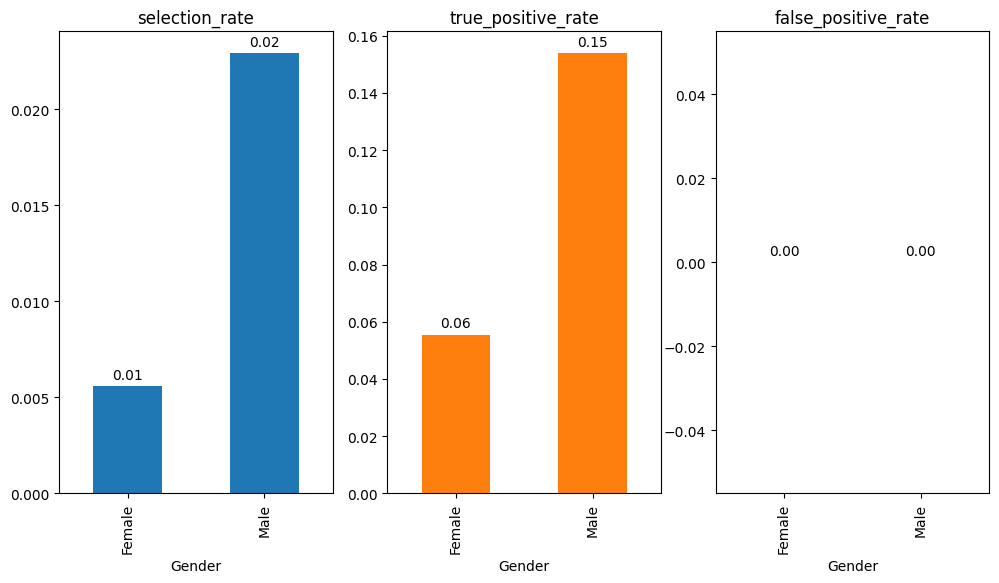



OverTime

          accuracy  selection_rate  true_positive_rate  true_negative_rate  \
OverTime                                                                     
No        0.929878        0.006098             0.08000                 1.0   
Yes       0.761062        0.044248             0.15625                 1.0   

          false_positive_rate  false_negative_rate  balanced_accuracy  
OverTime                                                               
No                        0.0              0.92000           0.540000  
Yes                       0.0              0.84375           0.578125  


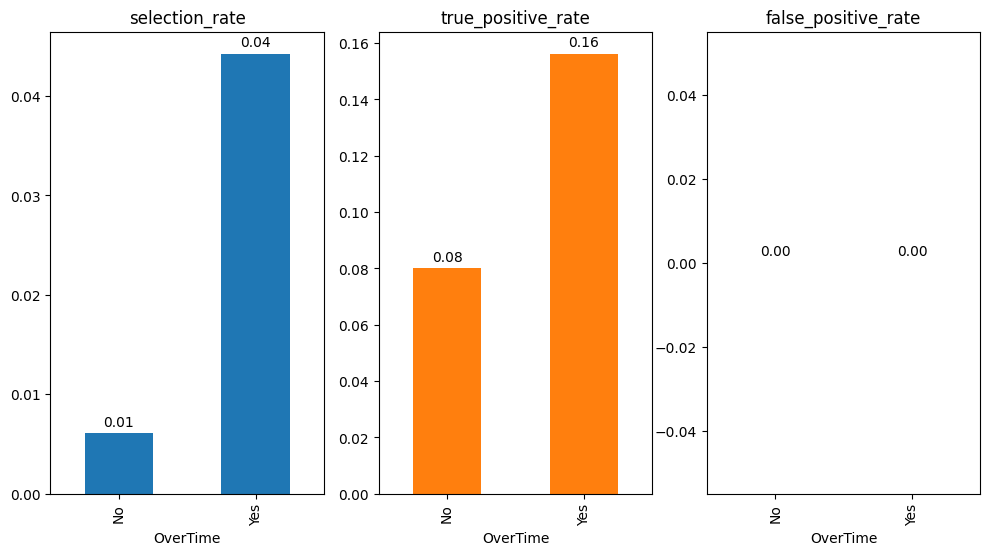



BusinessTravel

                   accuracy  selection_rate  true_positive_rate  \
BusinessTravel                                                    
Non-Travel         0.959184        0.000000            0.000000   
Travel_Frequently  0.825000        0.050000            0.222222   
Travel_Rarely      0.891026        0.009615            0.081081   

                   true_negative_rate  false_positive_rate  \
BusinessTravel                                               
Non-Travel                        1.0                  0.0   
Travel_Frequently                 1.0                  0.0   
Travel_Rarely                     1.0                  0.0   

                   false_negative_rate  balanced_accuracy  
BusinessTravel                                             
Non-Travel                    1.000000           0.500000  
Travel_Frequently             0.777778           0.611111  
Travel_Rarely                 0.918919           0.540541  


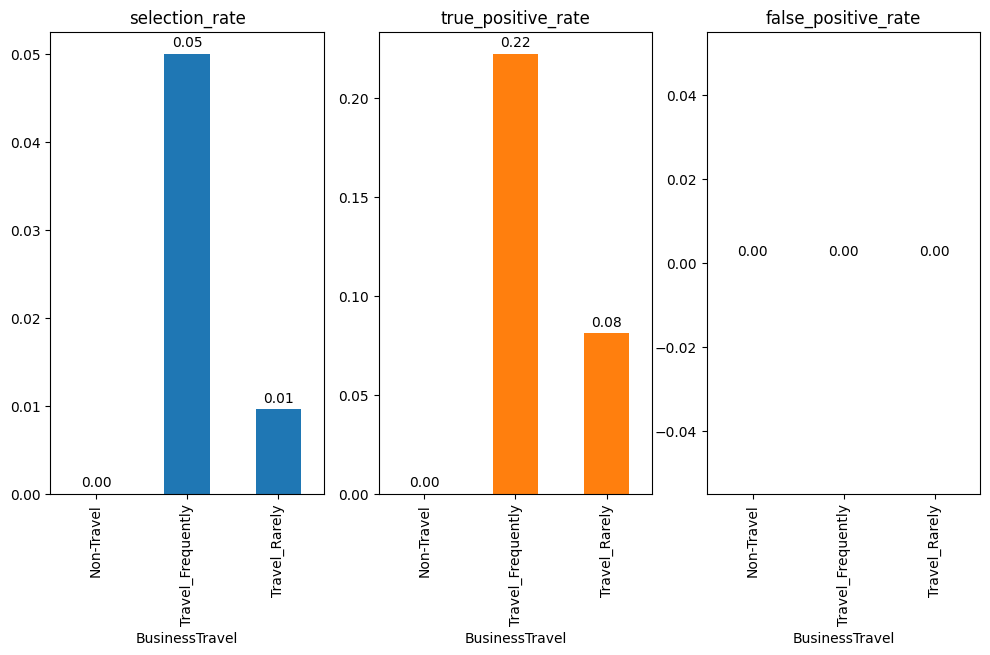



Department

                        accuracy  selection_rate  true_positive_rate  \
Department                                                             
Human Resources         0.866667        0.000000            0.000000   
Research & Development  0.914676        0.010239            0.107143   
Sales                   0.827068        0.030075            0.148148   

                        true_negative_rate  false_positive_rate  \
Department                                                        
Human Resources                        1.0                  0.0   
Research & Development                 1.0                  0.0   
Sales                                  1.0                  0.0   

                        false_negative_rate  balanced_accuracy  
Department                                                      
Human Resources                    1.000000           0.500000  
Research & Development             0.892857           0.553571  
Sales                        

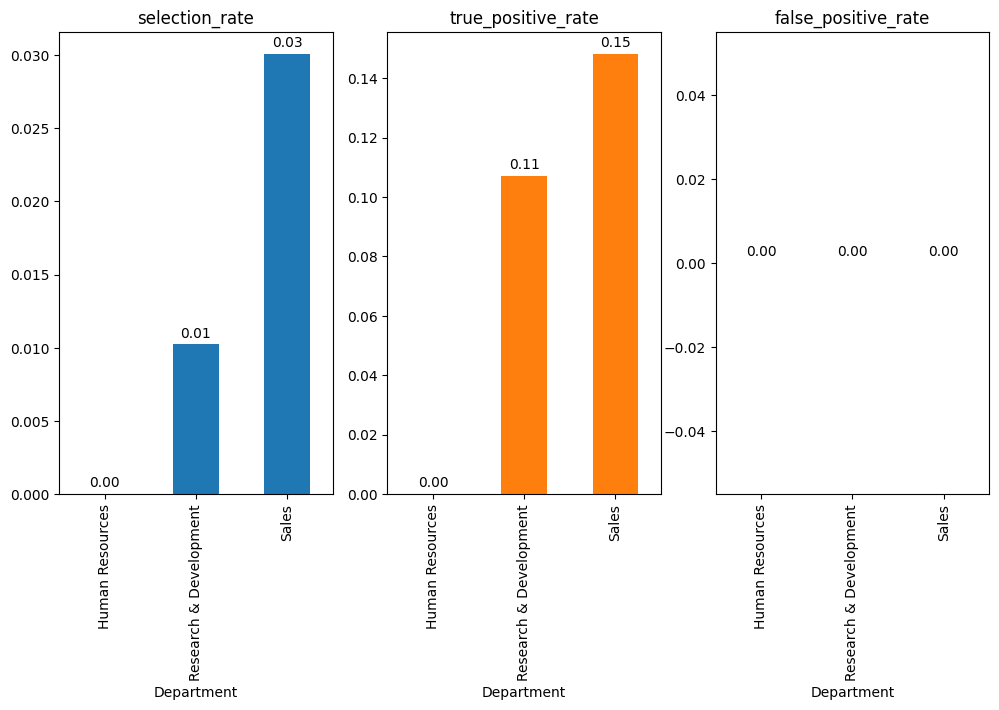



EducationField

                  accuracy  selection_rate  true_positive_rate  \
EducationField                                                   
Human Resources   1.000000        0.000000            0.000000   
Life Sciences     0.898876        0.022472            0.181818   
Marketing         0.839286        0.035714            0.181818   
Medical           0.889706        0.007353            0.062500   
Other             1.000000        0.000000            0.000000   
Technical Degree  0.822222        0.000000            0.000000   

                  true_negative_rate  false_positive_rate  \
EducationField                                              
Human Resources                  1.0                  0.0   
Life Sciences                    1.0                  0.0   
Marketing                        1.0                  0.0   
Medical                          1.0                  0.0   
Other                            1.0                  0.0   
Technical Degree          

d:\OneDrive\Repos\demo-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
d:\OneDrive\Repos\demo-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


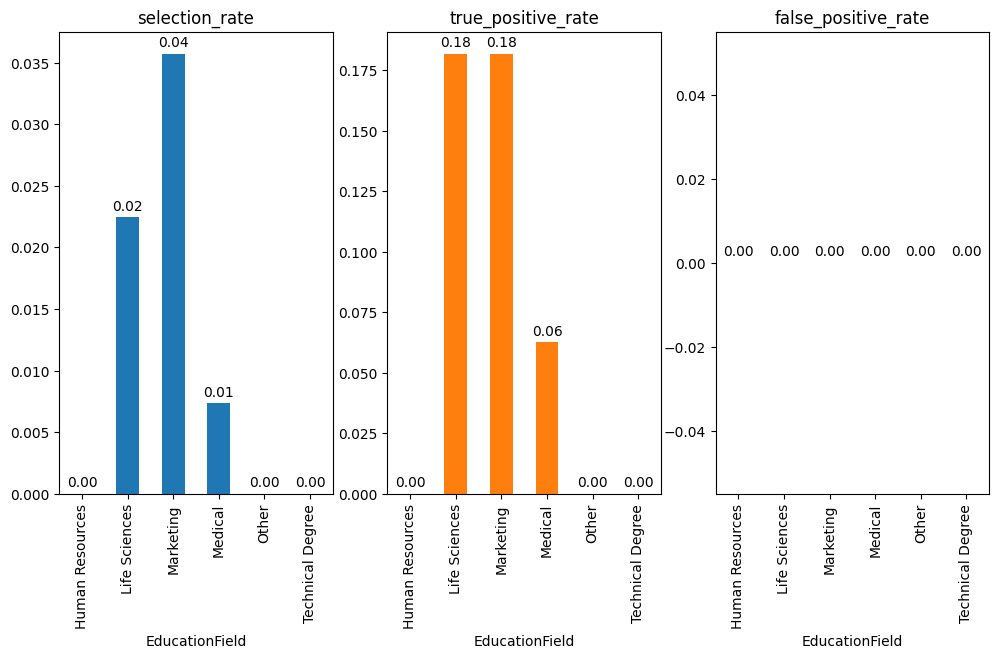



JobRole

                           accuracy  selection_rate  true_positive_rate  \
JobRole                                                                   
Healthcare Representative  0.979167        0.000000            0.000000   
Human Resources            0.857143        0.000000            0.000000   
Laboratory Technician      0.845070        0.014085            0.083333   
Manager                    0.972973        0.000000            0.000000   
Manufacturing Director     0.957447        0.000000            0.000000   
Research Director          0.960000        0.000000            0.000000   
Research Scientist         0.891566        0.024096            0.181818   
Sales Executive            0.802198        0.000000            0.000000   
Sales Representative       0.800000        0.160000            0.444444   

                           true_negative_rate  false_positive_rate  \
JobRole                                                              
Healthcare Representati

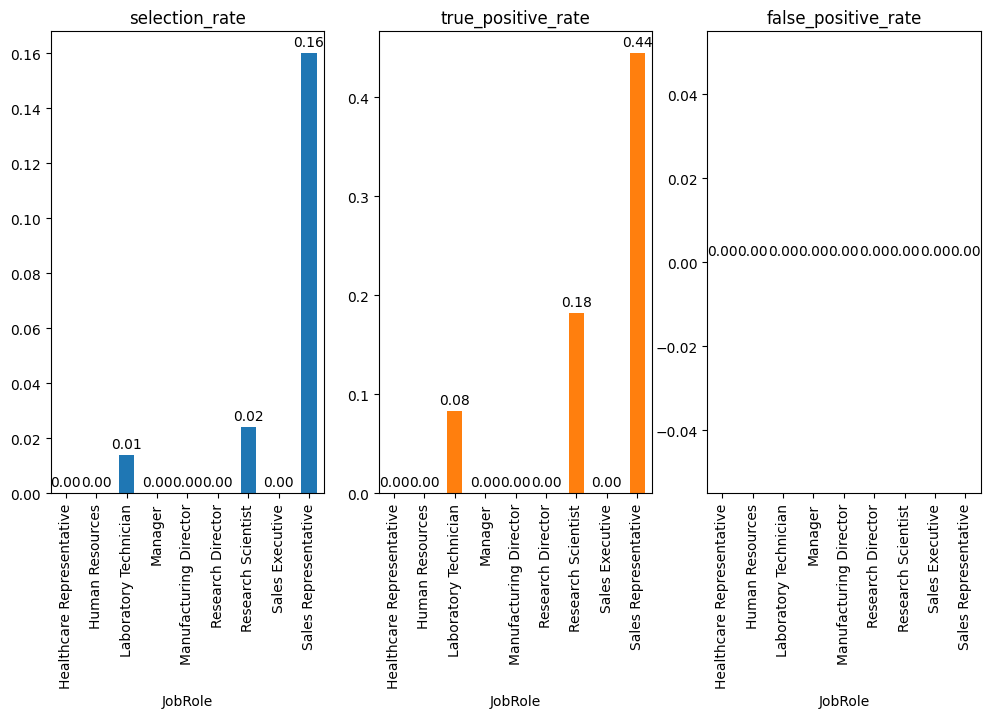



MaritalStatus

               accuracy  selection_rate  true_positive_rate  \
MaritalStatus                                                 
Divorced       0.946237        0.000000            0.000000   
Married        0.912195        0.004878            0.052632   
Single         0.811189        0.041958            0.181818   

               true_negative_rate  false_positive_rate  false_negative_rate  \
MaritalStatus                                                                 
Divorced                      1.0                  0.0             1.000000   
Married                       1.0                  0.0             0.947368   
Single                        1.0                  0.0             0.818182   

               balanced_accuracy  
MaritalStatus                     
Divorced                0.500000  
Married                 0.526316  
Single                  0.590909  


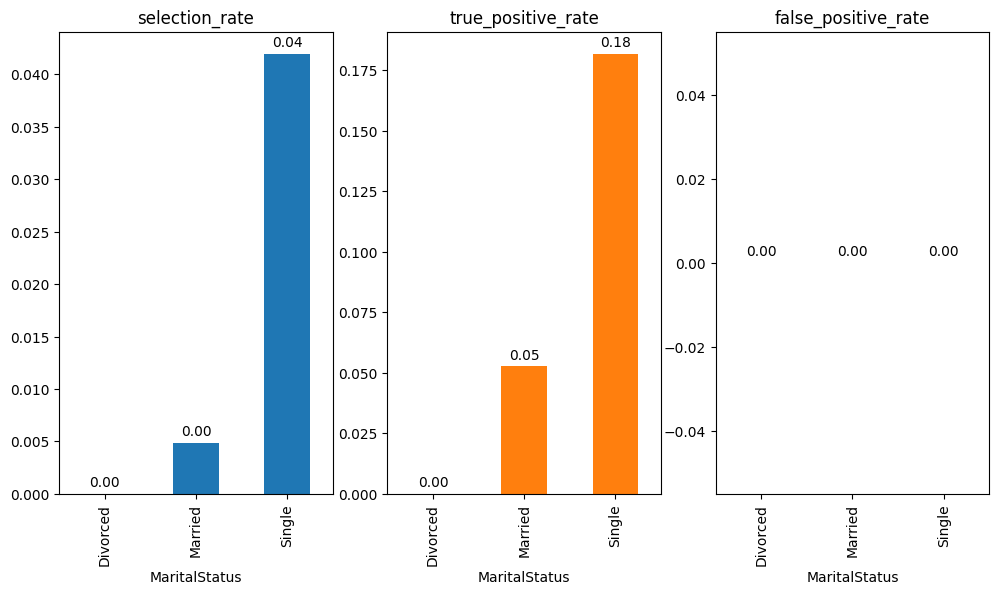

In [20]:
sensitive_attributes = ['Gender', 'OverTime'] + variable_ori_names

for sensitive_attribute in sensitive_attributes:
    print(sensitive_attribute+"\n")
    fairness_eval(sensitive_attribute)
    print("\n")